In [916]:
#A code to fit continuum, pseudo-continuum, and/or baselines to image cubes from the JWST nirspec ifu
#By Adam E. Rubinstein

# load important packages
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d, UnivariateSpline, CubicSpline
import os
import sys

from astropy import units as u
from astropy.io import fits
import pandas as pd
from photutils.aperture import RectangularAperture #, RectangularAnnulus, SkyCircularAperture
from spectral_cube import SpectralCube

# Setup for Baseline Techniques

In [859]:
#setting up some initial lists

from pybaselines import Baseline, misc #, utils
from scipy.signal import medfilt, savgol_filter

#used for plotting
protostar_names = ['IRAS 16253-2429', 'B335', 'HOPS 153', 'HOPS 370', 'IRAS 20126+4104'] 

#the original data
cube_file_list = ['IRAS16253/jw01802-o015_t012_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits', \
                    'B335/jw01802-o003_t001_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits', \
                    'HOPS153/jw01802-o019_t015_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits', \
                    'HOPS370/jw01802-o007_t004_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits', \
                    'IRAS20126/jw01802-o011_t007_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits']

#derived data or cubes
protostar_substr = ['IRAS16253', 'B335', 'HOPS153', 'HOPS370', 'IRAS20126']
absorb_emiss_path = 'Extended_CO_CO2/CO_Absorption_Emission_Maps/'
absorb_emiss_cube_list = [glob(absorb_emiss_path + i + '*cube*.fits')[0].replace('\\', '/') for i in protostar_substr]
absorb_emiss_txt_list = [glob(absorb_emiss_path + i + '*txt')[0].replace('\\', '/') for i in protostar_substr]

#source properties
central_sources_list = [[(47,45)], [(53,43), (45,43)], [(42, 45), (49, 54)], [(42, 38), (42, 46)], [(42, 43), (58, 52)]] #based on line to cont ratio
isotope_theta = [0.0, 0.0, 50.0, 0.0, 35.0]
arc_to_pix = 2.7777778191699e-05 * 3600.0 #take 1 pix in degrees, convert to arcsec, then can divide by this to convert
aper_dims = [(0.51, 0.51), (0.68, 0.68), (0.53, 0.53), (0.67, 0.67), (0.49, 0.44)] #arcsecs
source_names_list = ['IRAS 16253-2429', ['B335W', 'B335E'], ['HOPS 153SE', 'HOPS 153NW'], ['HOPS 370S', 'HOPS 370N'], ['IRAS 20126+4104SE', 'IRAS 20126+4104NW']]


# Saving data files and attempting to improve baselines

Text(0.5, 0, '$\\rm \\lambda \\ (\\mu m)$')

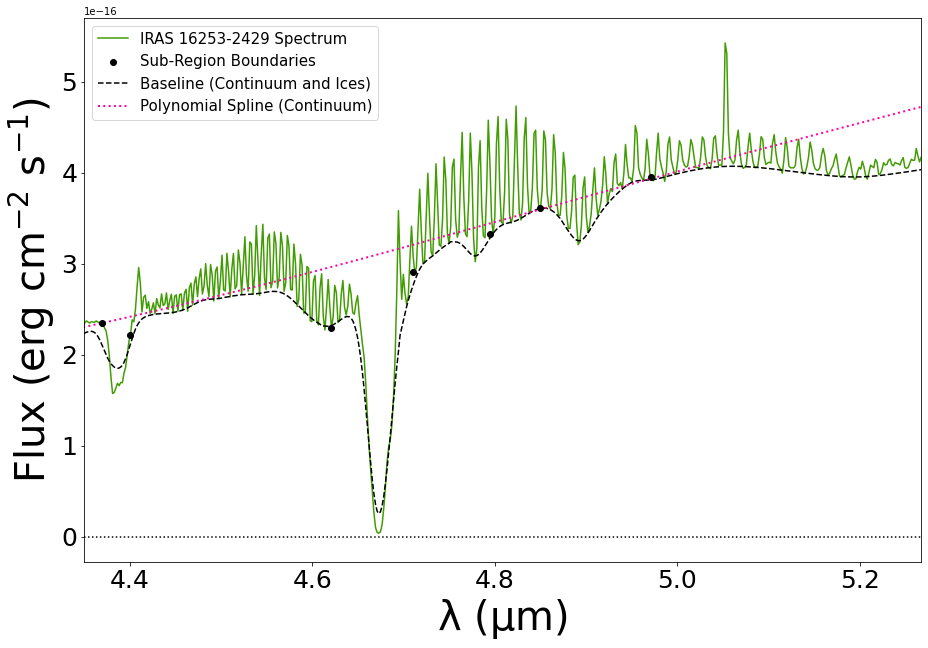

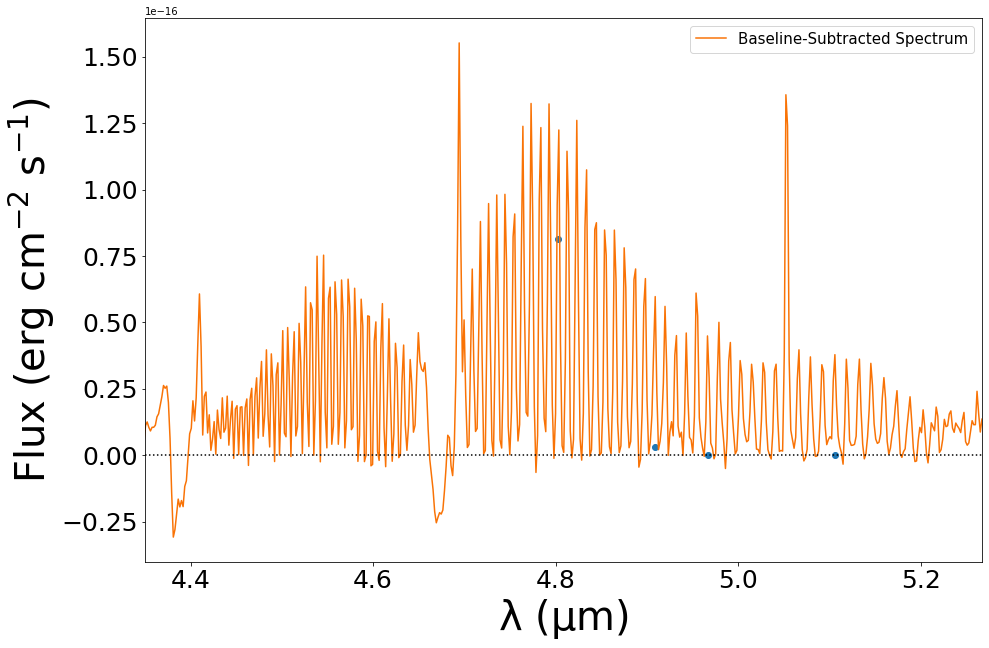

In [260]:
#testing an initial filter + interpolation for baselines

#read in some data
protostar_ind = 0 #CHANGE: to change protostars
hdul = fits.open(cube_file_list[protostar_ind])
jwst_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  
cube = fits.getdata(cube_file_list[protostar_ind])
err_cube = hdul['ERR'].data

# define the wavelength grid (microns) from the header, always the same
wave = np.array(jwst_cube.spectral_axis.value, dtype=np.float64)[1:-1]

#now that we have chosen a protostar...#create list of wavelength regimes to loop over; also labels for the different locations
wave_cutoff_list = np.array([4.19, 4.32, 4.37, 4.4, 4.62, 4.71, 4.795, 4.85, 4.971])
smooth_list = [1, 1, 10, 1, 5, 3, 3, 3, 3, 5] #, 2] #smoothing parameters for baseline #third to last originally 3
alpha_list = [1, 100, 50, 1, 1, 100, 1, 100, 100, 1e5] # , 7] #regularization parameter (relative levels of noise and signal)

#then set up a figure to loop over
fig, ax = plt.subplots(figsize=(15,10)) #setup fig, axes #make a figure to plot various locations on an image

#and loop over the axes and coordinates for a given object
# for i in range(len(ax_list)):
#     ax = ax_list[protostar_ind]

#need to do this first to get wavelengths and initialize some arrays for plotting spectra
hdul = fits.open(cube_file_list[protostar_ind]) #separated out line here since need to use hdul a few times
orig_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  

# define the wavelength grid (microns) from the header
# wave_offset = offset_list[protostar_ind] #unit = microns, alt value is 2e-4 microns, while cdelt is about E-9 m or E-3 mic...
wave_factor = 1 #/1.001 #for wavelength calibrating
wave_units = 1 #1e6 #to convert from meters to microns, for original data just set to 1
wave = wave_factor * wave_units * orig_cube.spectral_axis.value #+ wave_offset
wave = wave[1:-1] #need to make correct axis size

#set up units
photometric_head = hdul[1].header
delta_lambda = photometric_head['CDELT3'] #in microns ?
pixel_area = photometric_head['PIXAR_SR'] # in sr
sr_conversion = np.abs(photometric_head['CDELT1'] * photometric_head['CDELT2'] / (180. / np.pi)**2.0) #square degrees to steradians, should be consistent throughout all images (?)
cube_units = 1e6 * 1e-23 * 3e14/wave**2. * delta_lambda * pixel_area # * sr_conversion

#intialized arrays
orig_data = np.zeros(wave.shape) #to be filled in
err_data = np.zeros(wave.shape) #to be filled in

for k in range(len(central_sources_list[protostar_ind])):

    #now extract only a smaller portion from the general cubes
    rect_aper = RectangularAperture((central_sources_list[protostar_ind][k][0], central_sources_list[protostar_ind][k][1]), \
                                    aper_dims[protostar_ind][0]/arc_to_pix, aper_dims[protostar_ind][1]/arc_to_pix, theta=isotope_theta[protostar_ind]*np.pi/180) #only need to define once
    rect_mask = rect_aper.to_mask()

    #read in original data and noise
    data_list = [] #dummy list
    for data_2d in orig_cube._data[1:-1,:,:]: #loop through data to mask properly
        data_list.append(rect_mask.cutout(data_2d))
    orig_data += np.sum(np.array(data_list), axis=(1,2)) 

    data_list = [] #dummy list
    for data_2d in hdul['ERR'].data[1:-1,:,:]: #loop through data to mask properly
        data_list.append(rect_mask.cutout(data_2d))
    err_data += np.sum(np.array(data_list), axis=(1,2)) 

orig_data *= cube_units
err_data *= cube_units

# plotting extracted spectra
ax.plot(wave, orig_data, color='xkcd:grassy green', label=protostar_names[protostar_ind] + ' Spectrum') #plot observation here!

#preset the top hat filter version
baseline_fitter = Baseline(wave, check_finite=False)
bkg_top = baseline_fitter.tophat(orig_data, half_window=2)[0]

#formulating regimes to cutoff the spectrum and apply different smoothing factors
cutoffs_flux_matched = bkg_top[[np.abs(wave - i).argmin() for i in wave_cutoff_list]]
ax.scatter(wave_cutoff_list, cutoffs_flux_matched, color='black', zorder=100, label='Sub-Region Boundaries') #or can use oranges 

#begin to loop through different parameters, defining a new baseline for a given section of the spectrum
baseline_list = []

#if edge case at start, do it by hand to omit conditionals
# print('start', wave_cutoff_list[0])
cutoff_mask = wave < wave_cutoff_list[0] #define mask up to first marker
baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)     #compute baseline
baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[0],alpha=alpha_list[0])[0]
baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

#if between two values and not at the edge cases, we loop..
cutoff_ind = 1 #to count loops
while cutoff_ind <= len(wave_cutoff_list)-1:
    idx = (wave >= wave_cutoff_list[cutoff_ind-1]) & (wave <= wave_cutoff_list[cutoff_ind]) #logical masks joined with *
    cutoff_mask = np.where(idx)[0] #determine mask between two values
    # print('middle checks: ', cutoff_ind, wave_cutoff_list[cutoff_ind], len(orig_data[cutoff_mask]))

    #compute baseline
    baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)
    if cutoff_ind == len(wave_cutoff_list) - 1:
        baseline = baseline_fitter.pspline_asls(orig_data[cutoff_mask], lam=5, p=0.001, spline_degree=3)[0]
    elif cutoff_ind == len(wave_cutoff_list) - 3:
        baseline = baseline_fitter.pspline_asls(bkg_top[cutoff_mask], lam=1, p=0.0005, spline_degree=3)[0]
    else:
        baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
    baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

    #update counter for loop, do after everything else
    cutoff_ind += 1

#if edge case at end, do it by hand
# print('end', wave_cutoff_list[-1]) #print to confirm cutoff at end
cutoff_mask = wave > wave_cutoff_list[-1] #define mask past last marker
baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)     #compute baseline
if np.mean(orig_data[cutoff_mask] / err_data[cutoff_mask]) < 8:
    baseline = baseline_fitter.pspline_asls(orig_data[cutoff_mask], lam=5e5, p=0.4, spline_degree=2)[0] #, half_window=smooth_list[-1],alpha=alpha_list[-1])[0]
else:
    baseline = baseline_fitter.pspline_asls(orig_data[cutoff_mask], lam=1e3, p=0.01, spline_degree=3)[0] #, half_window=smooth_list[-1],alpha=alpha_list[-1])[0]
    # baseline = baseline_fitter.jbcd(orig_data[cutoff_mask], half_window=smooth_list[-1],alpha=alpha_list[-1])[0]
baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

#now trying to filter around our control or anchor points
N_res = 100. * 1e-3 #knowing that average spectral resolution for the instrument is about 1/1000 microns, then applying multiples of that
for cutoff_ind in range(len(wave_cutoff_list)):
    idx = ( wave >= (wave_cutoff_list[cutoff_ind]-N_res) ) & ( wave <= (wave_cutoff_list[cutoff_ind]+N_res) ) #logical masks joined with * using N_res
    idx_mask = np.where(idx)[0] #making mask
    baseline_list[idx_mask] = savgol_filter(baseline_list[idx_mask], polyorder=1, window_length=7) #in region around mask, apply filters

#plotting 
ax.plot(wave, baseline_list, 'k', label='Baseline (Continuum and Ices)', linestyle='--') #baseline
# ax.plot(wave, orig_data-baseline_list, color='xkcd:twilight blue', label='Line Emission') #data

#formulating a pseudo-continuum based on the baseline to determine ices and a transmission curve
baseline_fitter = Baseline(wave, check_finite=False)
ice_list = baseline_fitter.pspline_asls(baseline_list, lam=1e3, p=0.999, spline_degree=2)[0]
ax.plot(wave, ice_list, linewidth=2, color='xkcd:shocking pink', linestyle=':', label='Polynomial Spline (Continuum)') # or can use xkcd:carnation pink
# ax.plot(wave, baseline_list - ice_list, linewidth=2, color='xkcd:royal purple', linestyle='-.', label='Pseudo-ices')

#formatting plot
ax.axhline(0, color='k', linestyle=':') #a horizontal line at zero
# ax.set_xticks(np.arange(3, 5.25, 0.25))
# ax.set_ylim(2e-16, 5e-16)
ax.set_xlim(4.35, np.max(wave))
ax.tick_params(axis='both', which='major', labelsize=25)
ax.legend(loc='best', fontsize=15)
# if i == len(ax_list) - 1:
ax.set_ylabel(r'$\rm Flux \ (erg \ {cm}^{-2} \ {s}^{-1})$', fontsize=40)
ax.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=40)
# fig.savefig('CentralSource_CO/' + cube_file_list[protostar_ind].split('/')[0]+'_FindBaseline.pdf')

#save data then plot baseline-subtracted spectra and/or fits
spectra_savepath = 'Spectra1D_tests/'
with open(spectra_savepath + protostar_names[protostar_ind] + '_orig_1Dspectrum.txt', 'w') as output:
    output.write('Wavelength(micron), Intensity(cgs). Uncertainty(cgs)' + "\n")
    for index in range(len(wave)):
        output.write(str(wave[index]) + ", " + str((orig_data)[index]) + ", " + str((err_data)[index]) + "\n")


#save data then plot baseline-subtracted spectra and/or fits
spectra_savepath = 'Baseline/'
with open(spectra_savepath + protostar_names[protostar_ind] + '_baseline_1Dspectrum.txt', 'w') as output:
    output.write('Wavelength(micron), Intensity(cgs)' + "\n")
    for index in range(len(wave)):
        output.write(str(wave[index]) + ", " + str((baseline_list)[index])  + "\n")

#plotting fit
fig, ax = plt.subplots(figsize=(15,10)) #setup fig, axes #make a figure to plot various locations on an image
wavenum_list = np.array([1958.603542, 2013.352446, 2037.025324, 2082.002253]) #cm^-1
einsein_coeff_list = np.array([1.357E+01, 1.475E+01, 1.531E+01, 1.655E+01]) #cm^-1 / molec / cm^2
rel_int_list = np.array([3.915E-25, 4.512E-22, 5.134E-21, 1.435E-19])
gamma_self = np.array([.042, .047, .051, .059])
wave_line_list = 1.0 / wavenum_list * 1e4
ax.scatter(wave_line_list, rel_int_list * einsein_coeff_list / gamma_self * 1013250 / 5e5) #note 1 013 250 erg is = 1 mL * atm
ax.plot(wave, orig_data - baseline_list, color='xkcd:orange', label='Baseline-Subtracted Spectrum') #plot observation here!
# ax.plot(wave, err_data, color='xkcd:twilight blue', label='Error Cube Aperture Sum')
ax.axhline(0, color='k', linestyle=':') #a horizontal line at zero
ax.legend(loc='best', fontsize=15)
ax.set_xlim(4.35, np.max(wave))
ax.tick_params(axis='both', which='major', labelsize=25)
ax.set_ylabel(r'$\rm Flux \ (erg \ {cm}^{-2} \ {s}^{-1})$', fontsize=40)
ax.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=40)

Text(0.5, 0, '$\\rm \\lambda \\ (\\mu m)$')

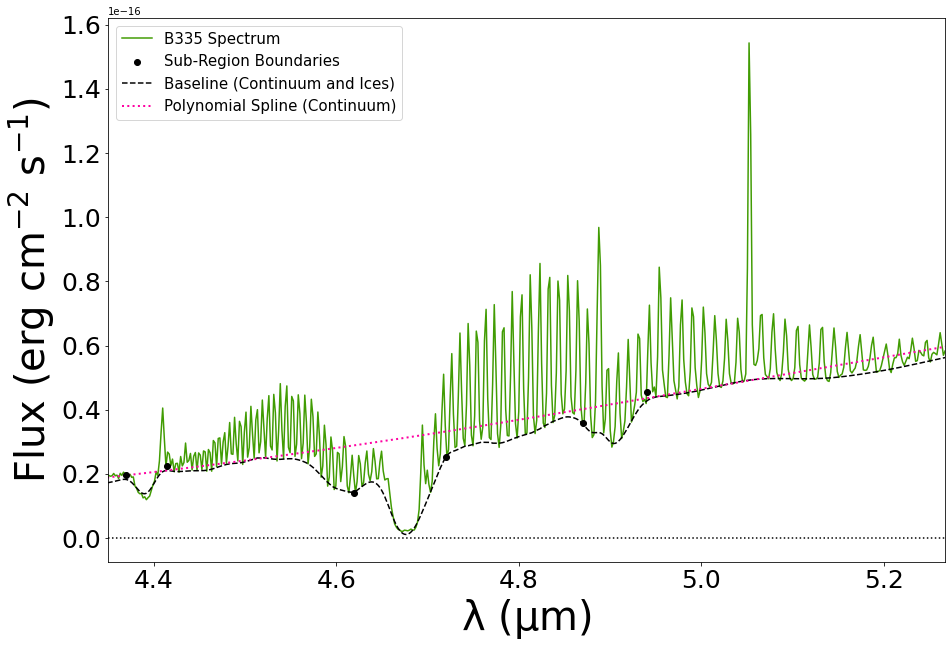

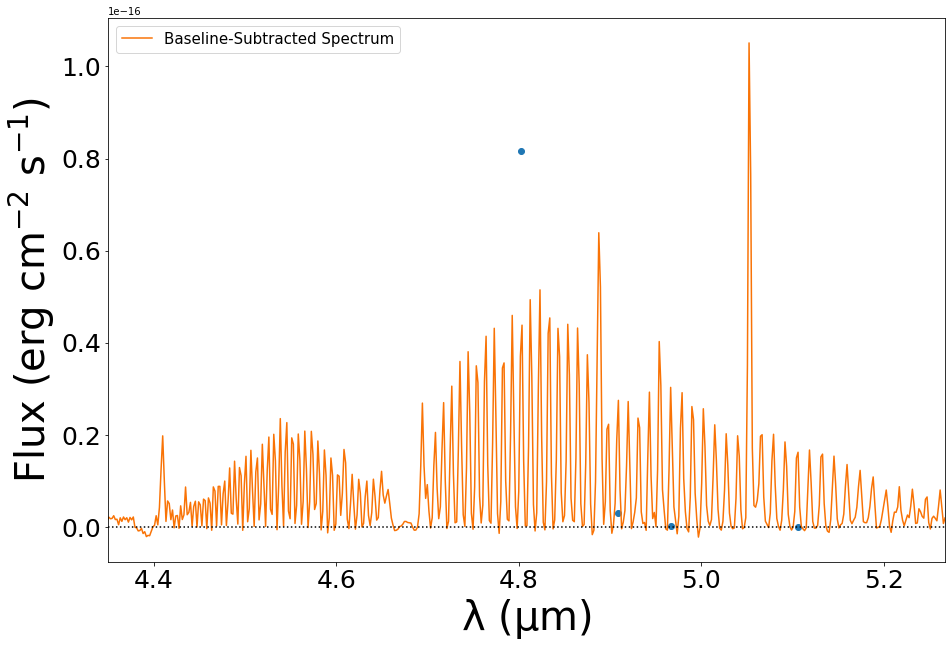

In [261]:
#testing an initial filter + interpolation for baselines

#read in some data
protostar_ind = 1 #CHANGE: to change protostars
hdul = fits.open(cube_file_list[protostar_ind])
jwst_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  
cube = fits.getdata(cube_file_list[protostar_ind])
err_cube = hdul['ERR'].data

# define the wavelength grid (microns) from the header, always the same
wave = np.array(jwst_cube.spectral_axis.value, dtype=np.float64)[1:-1]

#now that we have chosen a protostar...#create list of wavelength regimes to loop over; also labels for the different locations
wave_cutoff_list = np.array([4.19, 4.32, 4.37, 4.415, 4.62, 4.72, 4.87, 4.941])
smooth_list = [1, 1, 10, 1, 5, 3, 7, 2, 10] #smoothing parameters for baseline #third to last originally 3
alpha_list = [1, 100, 50, 100, 3, 100, 100, 7, 0.1] #regularization parameter (relative levels of noise and signal)

#then set up a figure to loop over
fig, ax = plt.subplots(figsize=(15,10)) #setup fig, axes #make a figure to plot various locations on an image

#and loop over the axes and coordinates for a given object
# for i in range(len(ax_list)):
#     ax = ax_list[protostar_ind]

#need to do this first to get wavelengths and initialize some arrays for plotting spectra
hdul = fits.open(cube_file_list[protostar_ind]) #separated out line here since need to use hdul a few times
orig_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  

# define the wavelength grid (microns) from the header
# wave_offset = offset_list[protostar_ind] #unit = microns, alt value is 2e-4 microns, while cdelt is about E-9 m or E-3 mic...
wave_factor = 1 #/1.001 #for wavelength calibrating
wave_units = 1 #1e6 #to convert from meters to microns, for original data just set to 1
wave = wave_factor * wave_units * orig_cube.spectral_axis.value #+ wave_offset
wave = wave[1:-1] #need to make correct axis size

#set up units
photometric_head = hdul[1].header
delta_lambda = photometric_head['CDELT3'] #in microns ?
pixel_area = photometric_head['PIXAR_SR'] # in sr
sr_conversion = np.abs(photometric_head['CDELT1'] * photometric_head['CDELT2'] / (180. / np.pi)**2.0) #square degrees to steradians, should be consistent throughout all images (?)
cube_units = 1e6 * 1e-23 * 3e14/wave**2. * delta_lambda * pixel_area # * sr_conversion

#intialized arrays
orig_data = np.zeros(wave.shape) #to be filled in
err_data = np.zeros(wave.shape) #to be filled in

for k in range(len(central_sources_list[protostar_ind])):

    #now extract only a smaller portion from the general cubes
    rect_aper = RectangularAperture((central_sources_list[protostar_ind][k][0], central_sources_list[protostar_ind][k][1]), \
                                    aper_dims[protostar_ind][0]/arc_to_pix, aper_dims[protostar_ind][1]/arc_to_pix, theta=isotope_theta[protostar_ind]*np.pi/180) #only need to define once
    rect_mask = rect_aper.to_mask()

    #read in original data and noise
    data_list = [] #dummy list
    for data_2d in orig_cube._data[1:-1,:,:]: #loop through data to mask properly
        data_list.append(rect_mask.cutout(data_2d))
    orig_data += np.sum(np.array(data_list), axis=(1,2)) 

    data_list = [] #dummy list
    for data_2d in hdul['ERR'].data[1:-1,:,:]: #loop through data to mask properly
        data_list.append(rect_mask.cutout(data_2d))
    err_data += np.sum(np.array(data_list), axis=(1,2)) 

orig_data *= cube_units
err_data *= cube_units

# plotting extracted spectra
ax.plot(wave, orig_data, color='xkcd:grassy green', label=protostar_names[protostar_ind] + ' Spectrum') #plot observation here!

#preset the top hat filter version
baseline_fitter = Baseline(wave, check_finite=False)
bkg_top = baseline_fitter.tophat(orig_data, half_window=2)[0]

#formulating regimes to cutoff the spectrum and apply different smoothing factors
cutoffs_flux_matched = bkg_top[[np.abs(wave - i).argmin() for i in wave_cutoff_list]]
ax.scatter(wave_cutoff_list, cutoffs_flux_matched, color='black', zorder=100, label='Sub-Region Boundaries') #or can use oranges 

#begin to loop through different parameters, defining a new baseline for a given section of the spectrum
baseline_list = []

#if edge case at start, do it by hand to omit conditionals
# print('start', wave_cutoff_list[0])
cutoff_mask = wave < wave_cutoff_list[0] #define mask up to first marker
baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)     #compute baseline
baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[0],alpha=alpha_list[0])[0]
baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

#if between two values and not at the edge cases, we loop..
cutoff_ind = 1 #to count loops
while cutoff_ind <= len(wave_cutoff_list)-1:
    idx = (wave >= wave_cutoff_list[cutoff_ind-1]) & (wave <= wave_cutoff_list[cutoff_ind]) #logical masks joined with *
    cutoff_mask = np.where(idx)[0] #determine mask between two values
    # print('middle checks: ', cutoff_ind, wave_cutoff_list[cutoff_ind], len(orig_data[cutoff_mask]))

    #compute baseline
    baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)
    if cutoff_ind == len(wave_cutoff_list) - 1:
        baseline = baseline_fitter.pspline_asls(orig_data[cutoff_mask], lam=5, p=0.001, spline_degree=3)[0]
    elif cutoff_ind == len(wave_cutoff_list) - 3:
        baseline = baseline_fitter.pspline_asls(bkg_top[cutoff_mask], lam=1, p=0.0005, spline_degree=3)[0]
    else:
        baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
    baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

    #update counter for loop, do after everything else
    cutoff_ind += 1

#if edge case at end, do it by hand
# print('end', wave_cutoff_list[-1]) #print to confirm cutoff at end
cutoff_mask = wave > wave_cutoff_list[-1] #define mask past last marker
baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)     #compute baseline
if np.mean(orig_data[cutoff_mask] / err_data[cutoff_mask]) < 8:
    baseline = baseline_fitter.pspline_asls(orig_data[cutoff_mask], lam=5e5, p=0.4, spline_degree=2)[0] #, half_window=smooth_list[-1],alpha=alpha_list[-1])[0]
else:
    baseline = baseline_fitter.pspline_asls(orig_data[cutoff_mask], lam=1e3, p=0.01, spline_degree=3)[0] #, half_window=smooth_list[-1],alpha=alpha_list[-1])[0]
    # baseline = baseline_fitter.jbcd(orig_data[cutoff_mask], half_window=smooth_list[-1],alpha=alpha_list[-1])[0]
baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

#now trying to filter around our control or anchor points
N_res = 100. * 1e-3 #knowing that average spectral resolution for the instrument is about 1/1000 microns, then applying multiples of that
for cutoff_ind in range(len(wave_cutoff_list)):
    idx = ( wave >= (wave_cutoff_list[cutoff_ind]-N_res) ) & ( wave <= (wave_cutoff_list[cutoff_ind]+N_res) ) #logical masks joined with * using N_res
    idx_mask = np.where(idx)[0] #making mask
    baseline_list[idx_mask] = savgol_filter(baseline_list[idx_mask], polyorder=1, window_length=7) #in region around mask, apply filters

#plotting 
ax.plot(wave, baseline_list, 'k', label='Baseline (Continuum and Ices)', linestyle='--') #baseline
# ax.plot(wave, orig_data-baseline_list, color='xkcd:twilight blue', label='Line Emission') #data

#formulating a pseudo-continuum based on the baseline to determine ices and a transmission curve
baseline_fitter = Baseline(wave, check_finite=False)
ice_list = baseline_fitter.pspline_asls(baseline_list, lam=1e3, p=0.999, spline_degree=2)[0]
ax.plot(wave, ice_list, linewidth=2, color='xkcd:shocking pink', linestyle=':', label='Polynomial Spline (Continuum)') # or can use xkcd:carnation pink
# ax.plot(wave, baseline_list - ice_list, linewidth=2, color='xkcd:royal purple', linestyle='-.', label='Pseudo-ices')

#formatting plot
ax.axhline(0, color='k', linestyle=':') #a horizontal line at zero
# ax.set_xticks(np.arange(3, 5.25, 0.25))
# ax.set_ylim(2e-16, 5e-16)
ax.set_xlim(4.35, np.max(wave))
ax.tick_params(axis='both', which='major', labelsize=25)
ax.legend(loc='best', fontsize=15)
# if i == len(ax_list) - 1:
ax.set_ylabel(r'$\rm Flux \ (erg \ {cm}^{-2} \ {s}^{-1})$', fontsize=40)
ax.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=40)
# fig.savefig('CentralSource_CO/' + cube_file_list[protostar_ind].split('/')[0]+'_FindBaseline.pdf')

#save data then plot baseline-subtracted spectra and/or fits
spectra_savepath = 'Spectra1D_tests/'
with open(spectra_savepath + protostar_names[protostar_ind] + '_orig_1Dspectrum.txt', 'w') as output:
    output.write('Wavelength(micron), Intensity(cgs). Uncertainty(cgs)' + "\n")
    for index in range(len(wave)):
        output.write(str(wave[index]) + ", " + str((orig_data)[index]) + ", " + str((err_data)[index]) + "\n")


#save data then plot baseline-subtracted spectra and/or fits
spectra_savepath = 'Baseline/'
with open(spectra_savepath + protostar_names[protostar_ind] + '_baseline_1Dspectrum.txt', 'w') as output:
    output.write('Wavelength(micron), Intensity(cgs)' + "\n")
    for index in range(len(wave)):
        output.write(str(wave[index]) + ", " + str((baseline_list)[index]) + "\n")

#plotting fit
fig, ax = plt.subplots(figsize=(15,10)) #setup fig, axes #make a figure to plot various locations on an image
wavenum_list = np.array([1958.603542, 2013.352446, 2037.025324, 2082.002253]) #cm^-1
einsein_coeff_list = np.array([1.357E+01, 1.475E+01, 1.531E+01, 1.655E+01]) #cm^-1 / molec / cm^2
rel_int_list = np.array([3.915E-25, 4.512E-22, 5.134E-21, 1.435E-19])
gamma_self = np.array([.042, .047, .051, .059])
wave_line_list = 1.0 / wavenum_list * 1e4
ax.scatter(wave_line_list, rel_int_list * einsein_coeff_list / gamma_self * 1013250 / 5e5) #note 1 013 250 erg is = 1 mL * atm
ax.plot(wave, orig_data - baseline_list, color='xkcd:orange', label='Baseline-Subtracted Spectrum') #plot observation here!
# ax.plot(wave, err_data, color='xkcd:twilight blue', label='Error Cube Aperture Sum')
ax.axhline(0, color='k', linestyle=':') #a horizontal line at zero
ax.legend(loc='best', fontsize=15)
ax.set_xlim(4.35, np.max(wave))
ax.tick_params(axis='both', which='major', labelsize=25)
ax.set_ylabel(r'$\rm Flux \ (erg \ {cm}^{-2} \ {s}^{-1})$', fontsize=40)
ax.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=40)

Text(0.5, 0, '$\\rm \\lambda \\ (\\mu m)$')

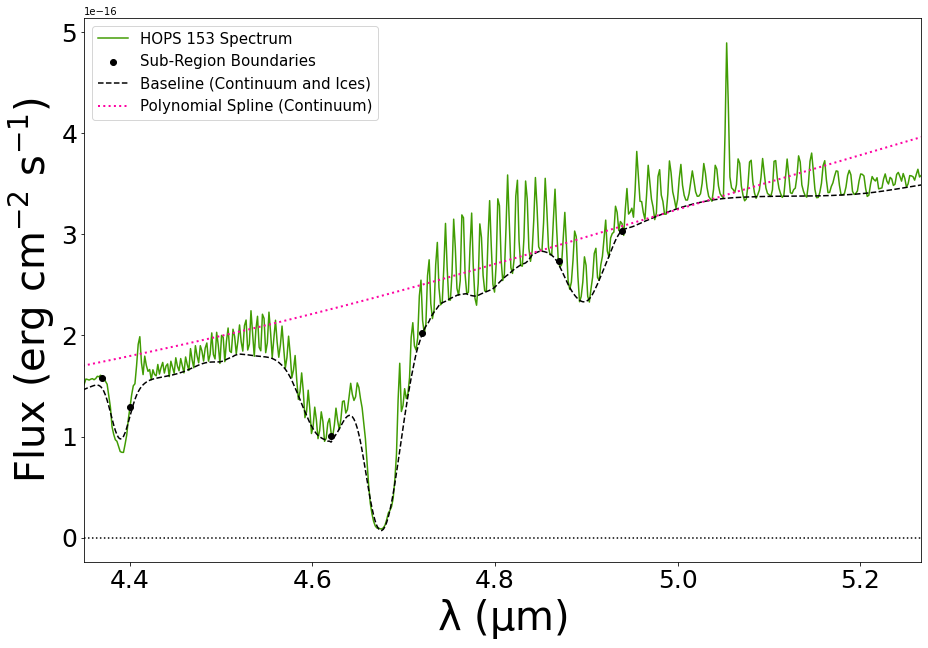

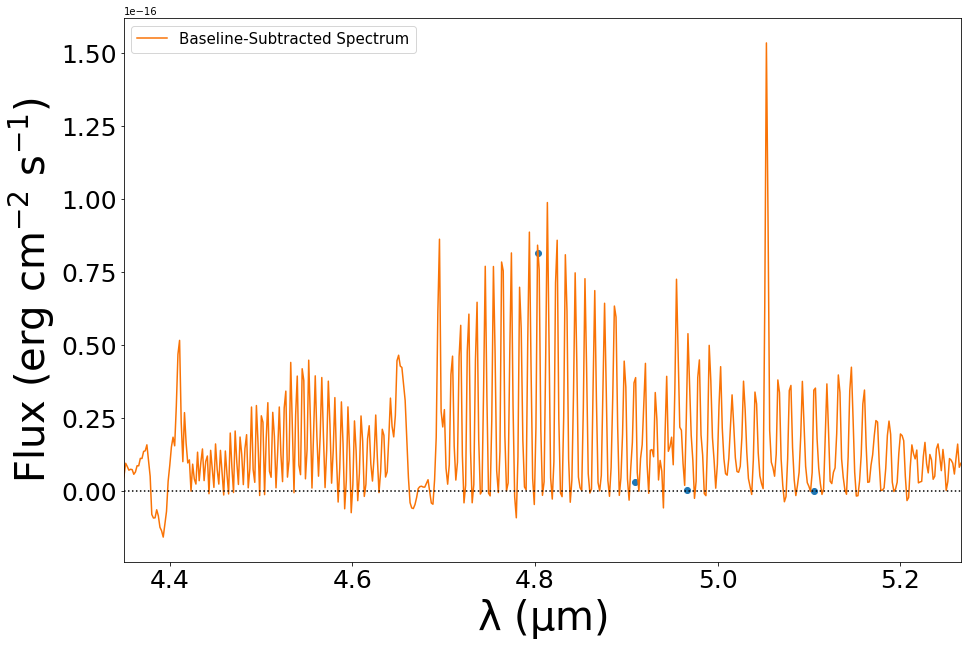

In [262]:
#testing an initial filter + interpolation for baselines

#read in some data
protostar_ind = 2 #CHANGE: to change protostars
hdul = fits.open(cube_file_list[protostar_ind])
jwst_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  
cube = fits.getdata(cube_file_list[protostar_ind])
err_cube = hdul['ERR'].data

# define the wavelength grid (microns) from the header, always the same
wave = np.array(jwst_cube.spectral_axis.value, dtype=np.float64)[1:-1]

#now that we have chosen a protostar...#create list of wavelength regimes to loop over; also labels for the different locations
wave_cutoff_list = np.array([4.19, 4.32, 4.37, 4.4, 4.62, 4.72, 4.87, 4.939])
smooth_list = [1, 1, 10, 1, 5, 3, 1, 2, 10] #smoothing parameters for baseline #third to last originally 3
alpha_list = [1, 100, 50, 100, 3, 100, 100, 7, 1] #regularization parameter (relative levels of noise and signal)

#then set up a figure to loop over
fig, ax = plt.subplots(figsize=(15,10)) #setup fig, axes #make a figure to plot various locations on an image

#and loop over the axes and coordinates for a given object
# for i in range(len(ax_list)):
#     ax = ax_list[protostar_ind]

#need to do this first to get wavelengths and initialize some arrays for plotting spectra
hdul = fits.open(cube_file_list[protostar_ind]) #separated out line here since need to use hdul a few times
orig_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  

# define the wavelength grid (microns) from the header
# wave_offset = offset_list[protostar_ind] #unit = microns, alt value is 2e-4 microns, while cdelt is about E-9 m or E-3 mic...
wave_factor = 1 #/1.001 #for wavelength calibrating
wave_units = 1 #1e6 #to convert from meters to microns, for original data just set to 1
wave = wave_factor * wave_units * orig_cube.spectral_axis.value #+ wave_offset
wave = wave[1:-1] #need to make correct axis size

#set up units
photometric_head = hdul[1].header
delta_lambda = photometric_head['CDELT3'] #in microns ?
pixel_area = photometric_head['PIXAR_SR'] # in sr
sr_conversion = np.abs(photometric_head['CDELT1'] * photometric_head['CDELT2'] / (180. / np.pi)**2.0) #square degrees to steradians, should be consistent throughout all images (?)
cube_units = 1e6 * 1e-23 * 3e14/wave**2. * delta_lambda * pixel_area # * sr_conversion

#intialized arrays
orig_data = np.zeros(wave.shape) #to be filled in
err_data = np.zeros(wave.shape) #to be filled in

for k in range(len(central_sources_list[protostar_ind])):

    #now extract only a smaller portion from the general cubes
    rect_aper = RectangularAperture((central_sources_list[protostar_ind][k][0], central_sources_list[protostar_ind][k][1]), \
                                    aper_dims[protostar_ind][0]/arc_to_pix, aper_dims[protostar_ind][1]/arc_to_pix, theta=isotope_theta[protostar_ind]*np.pi/180) #only need to define once
    rect_mask = rect_aper.to_mask()

    #read in original data and noise
    data_list = [] #dummy list
    for data_2d in orig_cube._data[1:-1,:,:]: #loop through data to mask properly
        data_list.append(rect_mask.cutout(data_2d))
    orig_data += np.sum(np.array(data_list), axis=(1,2)) 

    data_list = [] #dummy list
    for data_2d in hdul['ERR'].data[1:-1,:,:]: #loop through data to mask properly
        data_list.append(rect_mask.cutout(data_2d))
    err_data += np.sum(np.array(data_list), axis=(1,2)) 

orig_data *= cube_units
err_data *= cube_units

# plotting extracted spectra
ax.plot(wave, orig_data, color='xkcd:grassy green', label=protostar_names[protostar_ind] + ' Spectrum') #plot observation here!

#preset the top hat filter version
baseline_fitter = Baseline(wave, check_finite=False)
bkg_top = baseline_fitter.tophat(orig_data, half_window=2)[0]

#formulating regimes to cutoff the spectrum and apply different smoothing factors
cutoffs_flux_matched = bkg_top[[np.abs(wave - i).argmin() for i in wave_cutoff_list]]
ax.scatter(wave_cutoff_list, cutoffs_flux_matched, color='black', zorder=100, label='Sub-Region Boundaries') #or can use oranges 

#begin to loop through different parameters, defining a new baseline for a given section of the spectrum
baseline_list = []

#if edge case at start, do it by hand to omit conditionals
# print('start', wave_cutoff_list[0])
cutoff_mask = wave < wave_cutoff_list[0] #define mask up to first marker
baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)     #compute baseline
baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[0],alpha=alpha_list[0])[0]
baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

#if between two values and not at the edge cases, we loop..
cutoff_ind = 1 #to count loops
while cutoff_ind <= len(wave_cutoff_list)-1:
    idx = (wave >= wave_cutoff_list[cutoff_ind-1]) & (wave <= wave_cutoff_list[cutoff_ind]) #logical masks joined with *
    cutoff_mask = np.where(idx)[0] #determine mask between two values
    # print('middle checks: ', cutoff_ind, wave_cutoff_list[cutoff_ind], len(orig_data[cutoff_mask]))

    #compute baseline
    baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)
    if cutoff_ind == len(wave_cutoff_list) - 1:
        baseline = baseline_fitter.pspline_asls(orig_data[cutoff_mask], lam=5, p=0.001, spline_degree=3)[0]
    elif cutoff_ind == len(wave_cutoff_list) - 3:
        baseline = baseline_fitter.pspline_asls(bkg_top[cutoff_mask], lam=1, p=0.0005, spline_degree=3)[0]
    else:
        baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
    baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

    #update counter for loop, do after everything else
    cutoff_ind += 1

#if edge case at end, do it by hand
# print('end', wave_cutoff_list[-1]) #print to confirm cutoff at end
cutoff_mask = wave > wave_cutoff_list[-1] #define mask past last marker
baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)     #compute baseline
if np.mean(orig_data[cutoff_mask] / err_data[cutoff_mask]) < 8:
    baseline = baseline_fitter.pspline_asls(orig_data[cutoff_mask], lam=5e5, p=0.4, spline_degree=2)[0] #, half_window=smooth_list[-1],alpha=alpha_list[-1])[0]
else:
    baseline = baseline_fitter.pspline_asls(orig_data[cutoff_mask], lam=1e3, p=0.01, spline_degree=3)[0] #, half_window=smooth_list[-1],alpha=alpha_list[-1])[0]
    # baseline = baseline_fitter.jbcd(orig_data[cutoff_mask], half_window=smooth_list[-1],alpha=alpha_list[-1])[0]
baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

#now trying to filter around our control or anchor points
N_res = 100. * 1e-3 #knowing that average spectral resolution for the instrument is about 1/1000 microns, then applying multiples of that
for cutoff_ind in range(len(wave_cutoff_list)):
    idx = ( wave >= (wave_cutoff_list[cutoff_ind]-N_res) ) & ( wave <= (wave_cutoff_list[cutoff_ind]+N_res) ) #logical masks joined with * using N_res
    idx_mask = np.where(idx)[0] #making mask
    baseline_list[idx_mask] = savgol_filter(baseline_list[idx_mask], polyorder=1, window_length=7) #in region around mask, apply filters

#plotting 
ax.plot(wave, baseline_list, 'k', label='Baseline (Continuum and Ices)', linestyle='--') #baseline
# ax.plot(wave, orig_data-baseline_list, color='xkcd:twilight blue', label='Line Emission') #data

#formulating a pseudo-continuum based on the baseline to determine ices and a transmission curve
baseline_fitter = Baseline(wave, check_finite=False)
ice_list = baseline_fitter.pspline_asls(baseline_list, lam=1e3, p=0.999, spline_degree=2)[0]
ax.plot(wave, ice_list, linewidth=2, color='xkcd:shocking pink', linestyle=':', label='Polynomial Spline (Continuum)') # or can use xkcd:carnation pink
# ax.plot(wave, baseline_list - ice_list, linewidth=2, color='xkcd:royal purple', linestyle='-.', label='Pseudo-ices')

#formatting plot
ax.axhline(0, color='k', linestyle=':') #a horizontal line at zero
# ax.set_xticks(np.arange(3, 5.25, 0.25))
# ax.set_ylim(2e-16, 5e-16)
ax.set_xlim(4.35, np.max(wave))
ax.tick_params(axis='both', which='major', labelsize=25)
ax.legend(loc='best', fontsize=15)
# if i == len(ax_list) - 1:
ax.set_ylabel(r'$\rm Flux \ (erg \ {cm}^{-2} \ {s}^{-1})$', fontsize=40)
ax.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=40)
# fig.savefig('CentralSource_CO/' + cube_file_list[protostar_ind].split('/')[0]+'_FindBaseline.pdf')

#save data then plot baseline-subtracted spectra and/or fits
spectra_savepath = 'Spectra1D_tests/'
with open(spectra_savepath + protostar_names[protostar_ind] + '_orig_1Dspectrum.txt', 'w') as output:
    output.write('Wavelength(micron), Intensity(cgs). Uncertainty(cgs)' + "\n")
    for index in range(len(wave)):
        output.write(str(wave[index]) + ", " + str((orig_data)[index]) + ", " + str((err_data)[index]) + "\n")


#save data then plot baseline-subtracted spectra and/or fits
spectra_savepath = 'Baseline/'
with open(spectra_savepath + protostar_names[protostar_ind] + '_baseline_1Dspectrum.txt', 'w') as output:
    output.write('Wavelength(micron), Intensity(cgs)' + "\n")
    for index in range(len(wave)):
        output.write(str(wave[index]) + ", " + str((baseline_list)[index]) + "\n")

#plotting fit
fig, ax = plt.subplots(figsize=(15,10)) #setup fig, axes #make a figure to plot various locations on an image
wavenum_list = np.array([1958.603542, 2013.352446, 2037.025324, 2082.002253]) #cm^-1
einsein_coeff_list = np.array([1.357E+01, 1.475E+01, 1.531E+01, 1.655E+01]) #cm^-1 / molec / cm^2
rel_int_list = np.array([3.915E-25, 4.512E-22, 5.134E-21, 1.435E-19])
gamma_self = np.array([.042, .047, .051, .059])
wave_line_list = 1.0 / wavenum_list * 1e4
ax.scatter(wave_line_list, rel_int_list * einsein_coeff_list / gamma_self * 1013250 / 5e5) #note 1 013 250 erg is = 1 mL * atm
ax.plot(wave, orig_data - baseline_list, color='xkcd:orange', label='Baseline-Subtracted Spectrum') #plot observation here!
# ax.plot(wave, err_data, color='xkcd:twilight blue', label='Error Cube Aperture Sum')
ax.axhline(0, color='k', linestyle=':') #a horizontal line at zero
ax.legend(loc='best', fontsize=15)
ax.set_xlim(4.35, np.max(wave))
ax.tick_params(axis='both', which='major', labelsize=25)
ax.set_ylabel(r'$\rm Flux \ (erg \ {cm}^{-2} \ {s}^{-1})$', fontsize=40)
ax.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=40)

Text(0.5, 0, '$\\rm \\lambda \\ (\\mu m)$')

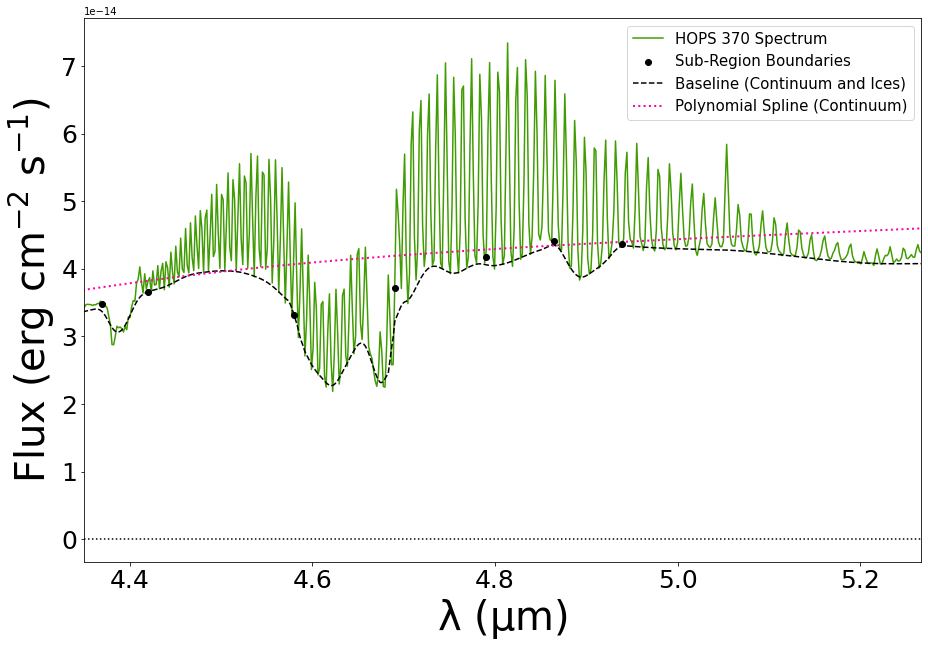

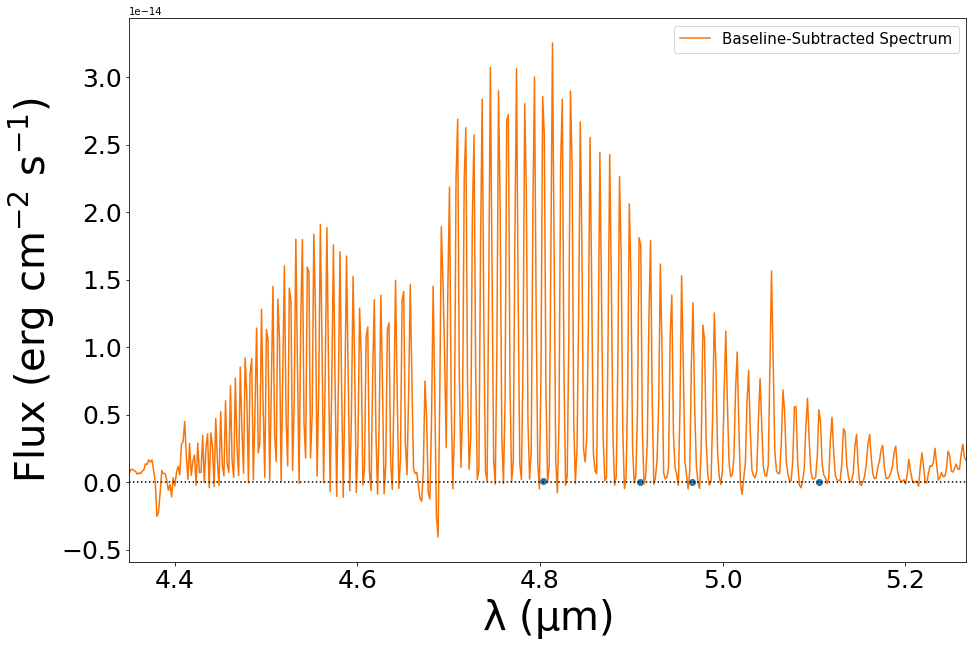

In [263]:
#testing an initial filter + interpolation for baselines

#read in some data
protostar_ind = 3 #CHANGE: to change protostars
hdul = fits.open(cube_file_list[protostar_ind])
jwst_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  
cube = fits.getdata(cube_file_list[protostar_ind])
err_cube = hdul['ERR'].data

# define the wavelength grid (microns) from the header, always the same
wave = np.array(jwst_cube.spectral_axis.value, dtype=np.float64)[1:-1]

#now that we have chosen a protostar...#create list of wavelength regimes to loop over; also labels for the different locations
wave_cutoff_list = np.array([4.19, 4.32, 4.37, 4.42, 4.58, 4.69, 4.79, 4.865, 4.939])
smooth_list = [1, 1, 10, 1, 5, 1, 10, 10, 2] #smoothing parameters for baseline #third to last originally 3
alpha_list = [1, 100, 50, 100, 3, 100, 1, 1, 7] #regularization parameter (relative levels of noise and signal)

#then set up a figure to loop over
fig, ax = plt.subplots(figsize=(15,10)) #setup fig, axes #make a figure to plot various locations on an image

#and loop over the axes and coordinates for a given object
# for i in range(len(ax_list)):
#     ax = ax_list[protostar_ind]

#need to do this first to get wavelengths and initialize some arrays for plotting spectra
hdul = fits.open(cube_file_list[protostar_ind]) #separated out line here since need to use hdul a few times
orig_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  

# define the wavelength grid (microns) from the header
# wave_offset = offset_list[protostar_ind] #unit = microns, alt value is 2e-4 microns, while cdelt is about E-9 m or E-3 mic...
wave_factor = 1 #/1.001 #for wavelength calibrating
wave_units = 1 #1e6 #to convert from meters to microns, for original data just set to 1
wave = wave_factor * wave_units * orig_cube.spectral_axis.value #+ wave_offset
wave = wave[1:-1] #need to make correct axis size

#set up units
photometric_head = hdul[1].header
delta_lambda = photometric_head['CDELT3'] #in microns ?
pixel_area = photometric_head['PIXAR_SR'] # in sr
sr_conversion = np.abs(photometric_head['CDELT1'] * photometric_head['CDELT2'] / (180. / np.pi)**2.0) #square degrees to steradians, should be consistent throughout all images (?)
cube_units = 1e6 * 1e-23 * 3e14/wave**2. * delta_lambda * pixel_area # * sr_conversion

#intialized arrays
orig_data = np.zeros(wave.shape) #to be filled in
err_data = np.zeros(wave.shape) #to be filled in

for k in range(len(central_sources_list[protostar_ind])):

    #now extract only a smaller portion from the general cubes
    rect_aper = RectangularAperture((central_sources_list[protostar_ind][k][0], central_sources_list[protostar_ind][k][1]), \
                                    aper_dims[protostar_ind][0]/arc_to_pix, aper_dims[protostar_ind][1]/arc_to_pix, theta=isotope_theta[protostar_ind]*np.pi/180) #only need to define once
    rect_mask = rect_aper.to_mask()

    #read in original data and noise
    data_list = [] #dummy list
    for data_2d in orig_cube._data[1:-1,:,:]: #loop through data to mask properly
        data_list.append(rect_mask.cutout(data_2d))
    orig_data += np.sum(np.array(data_list), axis=(1,2)) 

    data_list = [] #dummy list
    for data_2d in hdul['ERR'].data[1:-1,:,:]: #loop through data to mask properly
        data_list.append(rect_mask.cutout(data_2d))
    err_data += np.sum(np.array(data_list), axis=(1,2)) 

orig_data *= cube_units
err_data *= cube_units

# plotting extracted spectra
ax.plot(wave, orig_data, color='xkcd:grassy green', label=protostar_names[protostar_ind] + ' Spectrum') #plot observation here!

#preset the top hat filter version
baseline_fitter = Baseline(wave, check_finite=False)
bkg_top = baseline_fitter.tophat(orig_data, half_window=2)[0]

#formulating regimes to cutoff the spectrum and apply different smoothing factors
cutoffs_flux_matched = bkg_top[[np.abs(wave - i).argmin() for i in wave_cutoff_list]]
ax.scatter(wave_cutoff_list, cutoffs_flux_matched, color='black', zorder=100, label='Sub-Region Boundaries') #or can use oranges 

#begin to loop through different parameters, defining a new baseline for a given section of the spectrum
baseline_list = []

#if edge case at start, do it by hand to omit conditionals
# print('start', wave_cutoff_list[0])
cutoff_mask = wave < wave_cutoff_list[0] #define mask up to first marker
baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)     #compute baseline
baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[0],alpha=alpha_list[0])[0]
baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

#if between two values and not at the edge cases, we loop..
cutoff_ind = 1 #to count loops
while cutoff_ind <= len(wave_cutoff_list)-1:
    idx = (wave >= wave_cutoff_list[cutoff_ind-1]) & (wave <= wave_cutoff_list[cutoff_ind]) #logical masks joined with *
    cutoff_mask = np.where(idx)[0] #determine mask between two values
    # print('middle checks: ', cutoff_ind, wave_cutoff_list[cutoff_ind], len(orig_data[cutoff_mask]))

    #compute baseline
    baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)
    if cutoff_ind == len(wave_cutoff_list) - 1:
        baseline = baseline_fitter.pspline_asls(orig_data[cutoff_mask], lam=5, p=0.001, spline_degree=3)[0]
    elif cutoff_ind == len(wave_cutoff_list) - 3:
        baseline = baseline_fitter.pspline_asls(bkg_top[cutoff_mask], lam=1, p=0.0005, spline_degree=3)[0]
    else:
        baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
    baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

    #update counter for loop, do after everything else
    cutoff_ind += 1

#if edge case at end, do it by hand
# print('end', wave_cutoff_list[-1]) #print to confirm cutoff at end
cutoff_mask = wave > wave_cutoff_list[-1] #define mask past last marker
baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)     #compute baseline
if np.mean(orig_data[cutoff_mask] / err_data[cutoff_mask]) < 8:
    baseline = baseline_fitter.pspline_asls(orig_data[cutoff_mask], lam=5e5, p=0.4, spline_degree=2)[0] #, half_window=smooth_list[-1],alpha=alpha_list[-1])[0]
else:
    baseline = baseline_fitter.pspline_asls(orig_data[cutoff_mask], lam=1e3, p=0.01, spline_degree=3)[0] #, half_window=smooth_list[-1],alpha=alpha_list[-1])[0]
    # baseline = baseline_fitter.jbcd(orig_data[cutoff_mask], half_window=smooth_list[-1],alpha=alpha_list[-1])[0]
baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

#now trying to filter around our control or anchor points
N_res = 100. * 1e-3 #knowing that average spectral resolution for the instrument is about 1/1000 microns, then applying multiples of that
for cutoff_ind in range(len(wave_cutoff_list)):
    idx = ( wave >= (wave_cutoff_list[cutoff_ind]-N_res) ) & ( wave <= (wave_cutoff_list[cutoff_ind]+N_res) ) #logical masks joined with * using N_res
    idx_mask = np.where(idx)[0] #making mask
    baseline_list[idx_mask] = savgol_filter(baseline_list[idx_mask], polyorder=1, window_length=7) #in region around mask, apply filters

#plotting 
ax.plot(wave, baseline_list, 'k', label='Baseline (Continuum and Ices)', linestyle='--') #baseline
# ax.plot(wave, orig_data-baseline_list, color='xkcd:twilight blue', label='Line Emission') #data

#formulating a pseudo-continuum based on the baseline to determine ices and a transmission curve
baseline_fitter = Baseline(wave, check_finite=False)
ice_list = baseline_fitter.pspline_asls(baseline_list, lam=1e3, p=0.999, spline_degree=2)[0]
ax.plot(wave, ice_list, linewidth=2, color='xkcd:shocking pink', linestyle=':', label='Polynomial Spline (Continuum)') # or can use xkcd:carnation pink
# ax.plot(wave, baseline_list - ice_list, linewidth=2, color='xkcd:royal purple', linestyle='-.', label='Pseudo-ices')

#formatting plot
ax.axhline(0, color='k', linestyle=':') #a horizontal line at zero
# ax.set_xticks(np.arange(3, 5.25, 0.25))
# ax.set_ylim(2e-16, 5e-16)
ax.set_xlim(4.35, np.max(wave))
ax.tick_params(axis='both', which='major', labelsize=25)
ax.legend(loc='best', fontsize=15)
# if i == len(ax_list) - 1:
ax.set_ylabel(r'$\rm Flux \ (erg \ {cm}^{-2} \ {s}^{-1})$', fontsize=40)
ax.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=40)
# fig.savefig('CentralSource_CO/' + cube_file_list[protostar_ind].split('/')[0]+'_FindBaseline.pdf')

#save data then plot baseline-subtracted spectra and/or fits
spectra_savepath = 'Spectra1D_tests/'
with open(spectra_savepath + protostar_names[protostar_ind] + '_orig_1Dspectrum.txt', 'w') as output:
    output.write('Wavelength(micron), Intensity(cgs). Uncertainty(cgs)' + "\n")
    for index in range(len(wave)):
        output.write(str(wave[index]) + ", " + str((orig_data)[index]) + ", " + str((err_data)[index]) + "\n")
        

#save data then plot baseline-subtracted spectra and/or fits
spectra_savepath = 'Baseline/'
with open(spectra_savepath + protostar_names[protostar_ind] + '_baseline_1Dspectrum.txt', 'w') as output:
    output.write('Wavelength(micron), Intensity(cgs)' + "\n")
    for index in range(len(wave)):
        output.write(str(wave[index]) + ", " + str((baseline_list)[index]) + "\n")

#plotting fit
fig, ax = plt.subplots(figsize=(15,10)) #setup fig, axes #make a figure to plot various locations on an image
wavenum_list = np.array([1958.603542, 2013.352446, 2037.025324, 2082.002253]) #cm^-1
einsein_coeff_list = np.array([1.357E+01, 1.475E+01, 1.531E+01, 1.655E+01]) #cm^-1 / molec / cm^2
rel_int_list = np.array([3.915E-25, 4.512E-22, 5.134E-21, 1.435E-19])
gamma_self = np.array([.042, .047, .051, .059])
wave_line_list = 1.0 / wavenum_list * 1e4
ax.scatter(wave_line_list, rel_int_list * einsein_coeff_list / gamma_self * 1013250 / 5e5) #note 1 013 250 erg is = 1 mL * atm
ax.plot(wave, orig_data - baseline_list, color='xkcd:orange', label='Baseline-Subtracted Spectrum') #plot observation here!
# ax.plot(wave, err_data, color='xkcd:twilight blue', label='Error Cube Aperture Sum')
ax.axhline(0, color='k', linestyle=':') #a horizontal line at zero
ax.legend(loc='best', fontsize=15)
ax.set_xlim(4.35, np.max(wave))
ax.tick_params(axis='both', which='major', labelsize=25)
ax.set_ylabel(r'$\rm Flux \ (erg \ {cm}^{-2} \ {s}^{-1})$', fontsize=40)
ax.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=40)

Text(0.5, 0, '$\\rm \\lambda \\ (\\mu m)$')

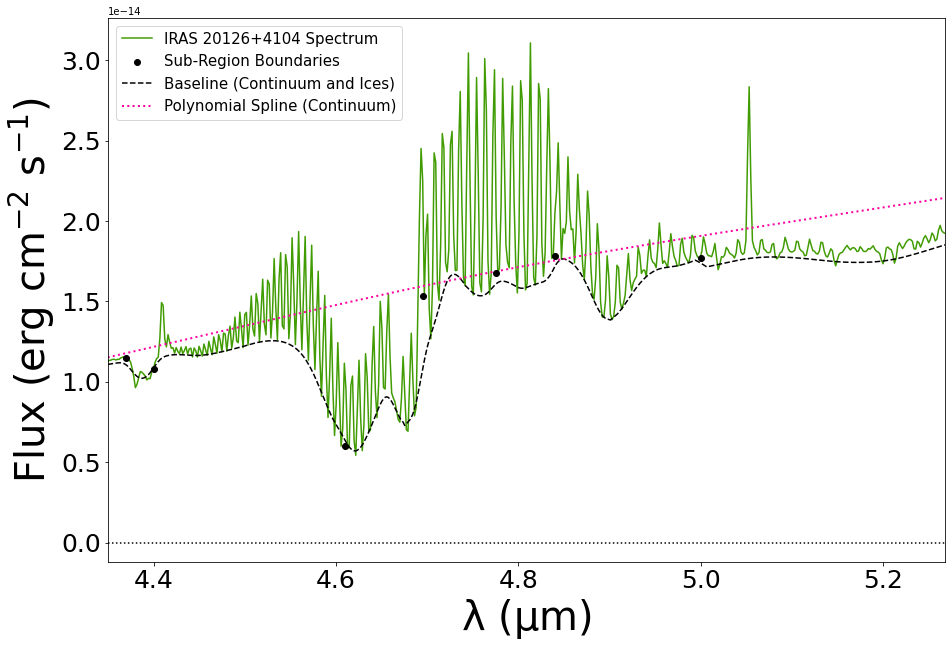

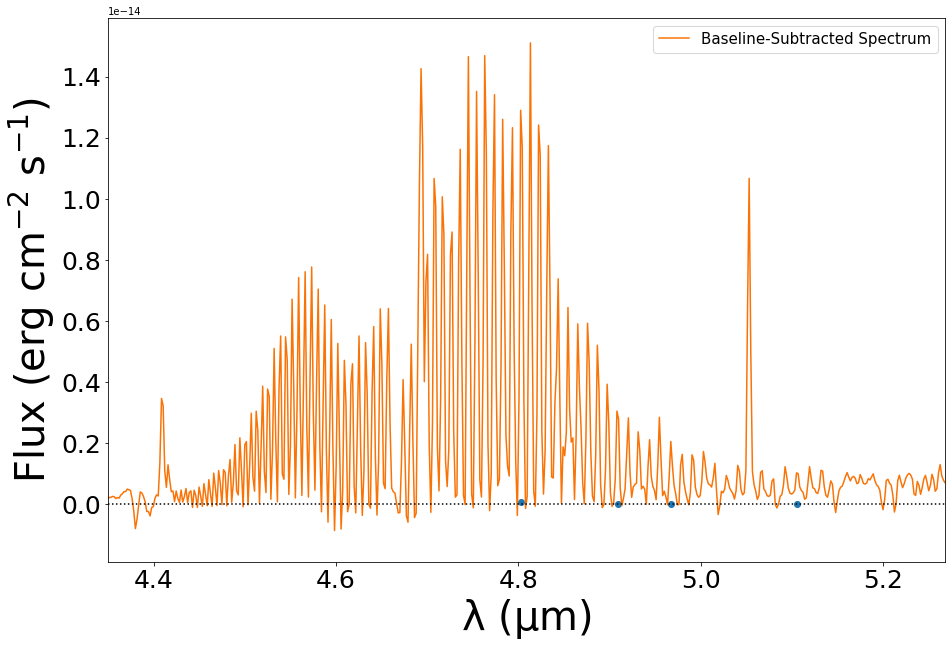

In [264]:
#testing an initial filter + interpolation for baselines

#read in some data
protostar_ind = 4 #CHANGE: to change protostars
hdul = fits.open(cube_file_list[protostar_ind])
jwst_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  
cube = fits.getdata(cube_file_list[protostar_ind])
err_cube = hdul['ERR'].data

# define the wavelength grid (microns) from the header, always the same
wave = np.array(jwst_cube.spectral_axis.value, dtype=np.float64)[1:-1]

#now that we have chosen a protostar...#create list of wavelength regimes to loop over; also labels for the different locations
wave_cutoff_list = np.array([4.19, 4.32, 4.37, 4.4, 4.61, 4.695, 4.775, 4.84, 5.0]) # 4.939
smooth_list = [1, 1, 10, 1, 5, 3, 15, 10, 2, 10] #smoothing parameters for baseline #third to last originally 3
alpha_list = [1, 100, 50, 100, 3, 100, 0.1, 100, 7, 1] #regularization parameter (relative levels of noise and signal)

#then set up a figure to loop over
fig, ax = plt.subplots(figsize=(15,10)) #setup fig, axes #make a figure to plot various locations on an image

#and loop over the axes and coordinates for a given object
# for i in range(len(ax_list)):
#     ax = ax_list[protostar_ind]

#need to do this first to get wavelengths and initialize some arrays for plotting spectra
hdul = fits.open(cube_file_list[protostar_ind]) #separated out line here since need to use hdul a few times
orig_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  

# define the wavelength grid (microns) from the header
# wave_offset = offset_list[protostar_ind] #unit = microns, alt value is 2e-4 microns, while cdelt is about E-9 m or E-3 mic...
wave_factor = 1 #/1.001 #for wavelength calibrating
wave_units = 1 #1e6 #to convert from meters to microns, for original data just set to 1
wave = wave_factor * wave_units * orig_cube.spectral_axis.value #+ wave_offset
wave = wave[1:-1] #need to make correct axis size

#set up units
photometric_head = hdul[1].header
delta_lambda = photometric_head['CDELT3'] #in microns ?
pixel_area = photometric_head['PIXAR_SR'] # in sr
sr_conversion = np.abs(photometric_head['CDELT1'] * photometric_head['CDELT2'] / (180. / np.pi)**2.0) #square degrees to steradians, should be consistent throughout all images (?)
cube_units = 1e6 * 1e-23 * 3e14/wave**2. * delta_lambda * pixel_area # * sr_conversion

#intialized arrays
orig_data = np.zeros(wave.shape) #to be filled in
err_data = np.zeros(wave.shape) #to be filled in

for k in range(len(central_sources_list[protostar_ind])):

    #now extract only a smaller portion from the general cubes
    rect_aper = RectangularAperture((central_sources_list[protostar_ind][k][0], central_sources_list[protostar_ind][k][1]), \
                                    aper_dims[protostar_ind][0]/arc_to_pix, aper_dims[protostar_ind][1]/arc_to_pix, theta=isotope_theta[protostar_ind]*np.pi/180) #only need to define once
    rect_mask = rect_aper.to_mask()

    #read in original data and noise
    data_list = [] #dummy list
    for data_2d in orig_cube._data[1:-1,:,:]: #loop through data to mask properly
        data_list.append(rect_mask.cutout(data_2d))
    orig_data += np.sum(np.array(data_list), axis=(1,2)) 

    data_list = [] #dummy list
    for data_2d in hdul['ERR'].data[1:-1,:,:]: #loop through data to mask properly
        data_list.append(rect_mask.cutout(data_2d))
    err_data += np.sum(np.array(data_list), axis=(1,2)) 

orig_data *= cube_units
err_data *= cube_units

# plotting extracted spectra
ax.plot(wave, orig_data, color='xkcd:grassy green', label=protostar_names[protostar_ind] + ' Spectrum') #plot observation here!

#preset the top hat filter version
baseline_fitter = Baseline(wave, check_finite=False)
bkg_top = baseline_fitter.tophat(orig_data, half_window=2)[0]

#formulating regimes to cutoff the spectrum and apply different smoothing factors
cutoffs_flux_matched = bkg_top[[np.abs(wave - i).argmin() for i in wave_cutoff_list]]
ax.scatter(wave_cutoff_list, cutoffs_flux_matched, color='black', zorder=100, label='Sub-Region Boundaries') #or can use oranges 

#begin to loop through different parameters, defining a new baseline for a given section of the spectrum
baseline_list = []

#if edge case at start, do it by hand to omit conditionals
# print('start', wave_cutoff_list[0])
cutoff_mask = wave < wave_cutoff_list[0] #define mask up to first marker
baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)     #compute baseline
baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[0],alpha=alpha_list[0])[0]
baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

#if between two values and not at the edge cases, we loop..
cutoff_ind = 1 #to count loops
while cutoff_ind <= len(wave_cutoff_list)-1:
    idx = (wave >= wave_cutoff_list[cutoff_ind-1]) & (wave <= wave_cutoff_list[cutoff_ind]) #logical masks joined with *
    cutoff_mask = np.where(idx)[0] #determine mask between two values
    # print('middle checks: ', cutoff_ind, wave_cutoff_list[cutoff_ind], len(orig_data[cutoff_mask]))

    #compute baseline
    baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)
    if cutoff_ind == len(wave_cutoff_list) - 1:
        baseline = baseline_fitter.pspline_asls(orig_data[cutoff_mask], lam=5, p=0.001, spline_degree=3)[0]
    elif cutoff_ind == len(wave_cutoff_list) - 3:
        baseline = baseline_fitter.pspline_asls(bkg_top[cutoff_mask], lam=1, p=0.0005, spline_degree=3)[0]
    else:
        baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
    baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

    #update counter for loop, do after everything else
    cutoff_ind += 1

#if edge case at end, do it by hand
# print('end', wave_cutoff_list[-1]) #print to confirm cutoff at end
cutoff_mask = wave > wave_cutoff_list[-1] #define mask past last marker
baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)     #compute baseline
if np.mean(orig_data[cutoff_mask] / err_data[cutoff_mask]) < 8:
    baseline = baseline_fitter.pspline_asls(orig_data[cutoff_mask], lam=5e5, p=0.4, spline_degree=2)[0] #, half_window=smooth_list[-1],alpha=alpha_list[-1])[0]
else:
    baseline = baseline_fitter.pspline_asls(orig_data[cutoff_mask], lam=1e3, p=0.01, spline_degree=3)[0] #, half_window=smooth_list[-1],alpha=alpha_list[-1])[0]
    # baseline = baseline_fitter.jbcd(orig_data[cutoff_mask], half_window=smooth_list[-1],alpha=alpha_list[-1])[0]
baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

#now trying to filter around our control or anchor points
N_res = 100. * 1e-3 #knowing that average spectral resolution for the instrument is about 1/1000 microns, then applying multiples of that
for cutoff_ind in range(len(wave_cutoff_list)):
    idx = ( wave >= (wave_cutoff_list[cutoff_ind]-N_res) ) & ( wave <= (wave_cutoff_list[cutoff_ind]+N_res) ) #logical masks joined with * using N_res
    idx_mask = np.where(idx)[0] #making mask
    baseline_list[idx_mask] = savgol_filter(baseline_list[idx_mask], polyorder=1, window_length=7) #in region around mask, apply filters

#plotting 
ax.plot(wave, baseline_list, 'k', label='Baseline (Continuum and Ices)', linestyle='--') #baseline
# ax.plot(wave, orig_data-baseline_list, color='xkcd:twilight blue', label='Line Emission') #data

#formulating a pseudo-continuum based on the baseline to determine ices and a transmission curve
baseline_fitter = Baseline(wave, check_finite=False)
ice_list = baseline_fitter.pspline_asls(baseline_list, lam=1e3, p=0.999, spline_degree=2)[0]
ax.plot(wave, ice_list, linewidth=2, color='xkcd:shocking pink', linestyle=':', label='Polynomial Spline (Continuum)') # or can use xkcd:carnation pink
# ax.plot(wave, baseline_list - ice_list, linewidth=2, color='xkcd:royal purple', linestyle='-.', label='Pseudo-ices')

#formatting plot
ax.axhline(0, color='k', linestyle=':') #a horizontal line at zero
# ax.set_xticks(np.arange(3, 5.25, 0.25))
# ax.set_ylim(2e-16, 5e-16)
ax.set_xlim(4.35, np.max(wave))
ax.tick_params(axis='both', which='major', labelsize=25)
ax.legend(loc='best', fontsize=15)
# if i == len(ax_list) - 1:
ax.set_ylabel(r'$\rm Flux \ (erg \ {cm}^{-2} \ {s}^{-1})$', fontsize=40)
ax.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=40)
# fig.savefig('CentralSource_CO/' + cube_file_list[protostar_ind].split('/')[0]+'_FindBaseline.pdf')

#save data then plot baseline-subtracted spectra and/or fits
spectra_savepath = 'Spectra1D_tests/'
with open(spectra_savepath + protostar_names[protostar_ind] + '_orig_1Dspectrum.txt', 'w') as output:
    output.write('Wavelength(micron), Intensity(cgs). Uncertainty(cgs)' + "\n")
    for index in range(len(wave)):
        output.write(str(wave[index]) + ", " + str((orig_data)[index]) + ", " + str((err_data)[index]) + "\n")


#save data then plot baseline-subtracted spectra and/or fits
spectra_savepath = 'Baseline/'
with open(spectra_savepath + protostar_names[protostar_ind] + '_baseline_1Dspectrum.txt', 'w') as output:
    output.write('Wavelength(micron), Intensity(cgs)' + "\n")
    for index in range(len(wave)):
        output.write(str(wave[index]) + ", " + str((baseline_list)[index]) + "\n")

#plotting fit
fig, ax = plt.subplots(figsize=(15,10)) #setup fig, axes #make a figure to plot various locations on an image
wavenum_list = np.array([1958.603542, 2013.352446, 2037.025324, 2082.002253]) #cm^-1
einsein_coeff_list = np.array([1.357E+01, 1.475E+01, 1.531E+01, 1.655E+01]) #cm^-1 / molec / cm^2
rel_int_list = np.array([3.915E-25, 4.512E-22, 5.134E-21, 1.435E-19])
gamma_self = np.array([.042, .047, .051, .059])
wave_line_list = 1.0 / wavenum_list * 1e4
ax.scatter(wave_line_list, rel_int_list * einsein_coeff_list / gamma_self * 1013250 / 5e5) #note 1 013 250 erg is = 1 mL * atm
ax.plot(wave, orig_data - baseline_list, color='xkcd:orange', label='Baseline-Subtracted Spectrum') #plot observation here!
# ax.plot(wave, err_data, color='xkcd:twilight blue', label='Error Cube Aperture Sum')
ax.axhline(0, color='k', linestyle=':') #a horizontal line at zero
ax.legend(loc='best', fontsize=15)
ax.set_xlim(4.35, np.max(wave))
ax.tick_params(axis='both', which='major', labelsize=25)
ax.set_ylabel(r'$\rm Flux \ (erg \ {cm}^{-2} \ {s}^{-1})$', fontsize=40)
ax.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=40)